In [1]:
# imports
import time
from datetime import datetime
import pytz
from collections import deque

# library imports
import requests
from tqdm.auto import tqdm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pacswg.timer import TimerClass

# config
my_timezone = os.getenv('PY_TZ', 'America/Toronto')

# small functions
def get_time_with_tz():
    return datetime.now().astimezone(pytz.timezone(my_timezone))

In [2]:
# configs
server_address = 'http://localhost:3000'

# service_name = 'tfserving-resnetv2'
# slo_timeout = 

# service_name = 'bentoml-onnx-resnet50'
# slo_timeout = 

service_name = 'bentoml-iris'
slo_timeout = 500
initial_batch_size = 5
bs_config = {
    'max_bs': 100,
    'min_bs': 1,
    'inc_step': 5,
    'dec_mult': 0.7,
}
average_timeout_ratio_threshold = 0.5

# service_name = 'tfserving-mobilenetv1'
# slo_timeout = 

# SLO
slo_target = slo_timeout * 0.8

# length of measurements used to estimate different batch size response times
upstream_rt_max_len = 1000

# Getting and Setting Stats and Configs

In [3]:
def fetch_raw_server_proxy_stats():
    url = f'{server_address}/proxy-monitor/{service_name}'
    response = requests.get(url)
    response.raise_for_status()
    return response.json()

def get_proxy_stats():
    raw_stats = fetch_raw_server_proxy_stats()
    return {
        'maxBufferSize': raw_stats['maxBufferSize'],
        'averageMaxBufferSize': raw_stats['windowedHistoryValues']['maxBufferSize']['average'],
        'averageActualBatchSize': raw_stats['windowedUpstream']['batchSizes']['average'],
        'maxBufferTimeoutMs': raw_stats['maxBufferTimeoutMs'],
        'currentReplicaCount': raw_stats['currentMonitorStatus']['currentReplicaCount'],
        'currentReadyReplicaCount': raw_stats['currentMonitorStatus']['currentReplicaCount'],
        'currentConcurrency': raw_stats['currentMonitorStatus']['currentConcurrency'],
        'averageConcurrency': raw_stats['windowedHistoryValues']['concurrency']['average'],
        'averageArrivalRate': raw_stats['windowedHistoryValues']['arrival']['rate'],
        'averageDepartureRate': raw_stats['windowedHistoryValues']['departure']['rate'],
        'averageDispatchRate': raw_stats['windowedHistoryValues']['dispatch']['rate'],
        'averageErrorRate': raw_stats['windowedHistoryValues']['error']['rate'],
        'averageTimeoutRatio': raw_stats['windowedHistoryValues']['timeoutRatio']['average'],
        'reponseTimeAverage': raw_stats['responseTimes']['stats']['average'],
        'reponseTimeP50': raw_stats['responseTimes']['stats']['q50'],
        'reponseTimeP95': raw_stats['responseTimes']['stats']['q95'],
        'batchResponseTimeStats': raw_stats['windowedUpstream']['responseTimes'],
    }

def set_proxy_config(update_config):
    url = f'{server_address}/proxy-config/{service_name}'
    response = requests.post(url, json=update_config)
    response.raise_for_status()
    return response.json()


# display(fetch_raw_server_proxy_stats())
# display(get_proxy_stats())
set_proxy_config({
    'maxBufferSize': initial_batch_size,
    'maxBufferTimeoutMs': slo_target,
})

{'serviceName': 'bentoml-iris',
 'upstreamUrl': 'http://bentoml-iris.default.kn.nima-dev.com/predict',
 'maxBufferTimeoutMs': 400,
 'maxBufferSize': 5,
 'isTFServing': False}

In [4]:
proxy_stats = get_proxy_stats()
proxy_stats

{'maxBufferSize': 5,
 'averageMaxBufferSize': 7,
 'averageActualBatchSize': 2.7222222222222223,
 'maxBufferTimeoutMs': 400,
 'currentReplicaCount': 1,
 'currentReadyReplicaCount': 1,
 'currentConcurrency': 2,
 'averageConcurrency': 0.7,
 'averageArrivalRate': 5,
 'averageDepartureRate': 5.05,
 'averageDispatchRate': 5.05,
 'averageErrorRate': 0,
 'averageTimeoutRatio': 1,
 'reponseTimeAverage': 249.98979591836735,
 'reponseTimeP50': 259,
 'reponseTimeP95': 384.34999999999997,
 'batchResponseTimeStats': {'1': {'values': [22,
    25,
    26,
    26,
    26,
    27,
    27,
    27,
    28,
    28,
    30,
    31,
    31,
    32,
    35,
    35,
    35,
    37,
    47],
   'stats': {'q50': 28,
    'q95': 37.99999999999998,
    'average': 30.263157894736842,
    'count': 19},
   'batchSize': 1},
  '2': {'values': [19,
    20,
    20,
    21,
    22,
    22,
    22,
    24,
    24,
    25,
    26,
    26,
    26,
    27,
    27,
    27,
    27,
    28,
    28,
    29,
    29,
    29,
    29,

In [5]:
def update_batch_rt_values(batch_rt_values, proxy_stats):
    for batch_size_str in proxy_stats['batchResponseTimeStats']:
        batch_size = int(batch_size_str)
        if not(batch_size in batch_rt_values):
            batch_rt_values[batch_size] = deque(maxlen=upstream_rt_max_len)
        # concatenate arrays
        batch_rt_values[batch_size].extend(proxy_stats['batchResponseTimeStats'][batch_size_str]['values'])

    return batch_rt_values

batch_rt_values = {}
batch_rt_values = update_batch_rt_values(batch_rt_values, proxy_stats)

In [6]:
# run a loop to monitor response times to test the functionality
timer = TimerClass()

batch_rt_values = {}
for _ in tqdm(range(1*6)):
    timer.tic()
    proxy_stats = get_proxy_stats()
    batch_rt_values = update_batch_rt_values(batch_rt_values, proxy_stats)
    while timer.toc() < 10:
        time.sleep(1)


  0%|          | 0/6 [00:00<?, ?it/s]

,batch_size,average_response_time,median_response_time,p95_response_time
0,1,28.744000,28.0,35.0
1,2,28.298643,29.0,35.0
2,3,28.346405,28.0,35.0
3,4,28.486111,28.0,44.0
4,5,27.680000,28.0,34.0
5,6,31.956522,32.0,39.0
6,7,27.000000,27.0,27.0


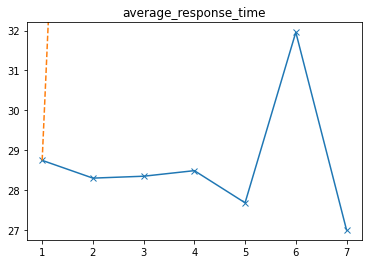

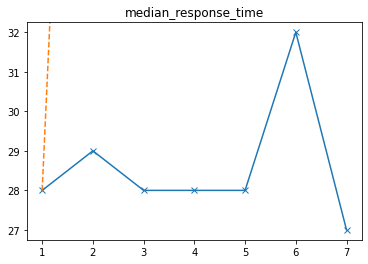

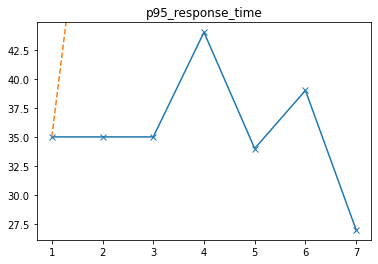

In [7]:
def analyze_batch_results(batch_rt_values):
    batch_size_results = []
    for bs, vals in batch_rt_values.items():
        # print(bs, len(vals), np.mean(vals))
        batch_size_results.append({
            'batch_size': bs,
            'average_response_time': np.mean(vals),
            'median_response_time': np.median(vals),
            'p95_response_time': np.percentile(vals,95),
        })

    df_batch_size = pd.DataFrame(data=batch_size_results)
    df_batch_size = df_batch_size.sort_values(by='batch_size')
    return df_batch_size

def plot_key_vs_batch_size(key, df_batch_size):
    plt.figure()
    plt.plot(df_batch_size['batch_size'], df_batch_size[key], marker='x')
    prev_ylim = plt.gca().get_ylim()
    # relative average response time by batch size (linear scale)
    relative_scaled_response_time = df_batch_size['batch_size']/df_batch_size['batch_size'].iloc[0]*df_batch_size[key].iloc[0]
    # plot the linear baseline
    plt.plot(df_batch_size['batch_size'], relative_scaled_response_time, ls='--')
    plt.ylim(prev_ylim)
    plt.title(key)

df_batch_size = analyze_batch_results(batch_rt_values)
display(df_batch_size)
plot_key_vs_batch_size('average_response_time', df_batch_size)
plot_key_vs_batch_size('median_response_time', df_batch_size)
plot_key_vs_batch_size('p95_response_time', df_batch_size)

# Create Control Algorithms

In [8]:
def calculate_new_bs(curr_bs, inc=True, config=None):
    if config is None:
        config = {
            'max_bs': 100,
            'min_bs': 20,
            'inc_step': 1,
            'dec_mult': 0.7,
        }

    if inc:
        new_bs = curr_bs + config['inc_step']
        # at least one step is made
        new_bs = max(new_bs, curr_bs+1)
    else:
        new_bs = curr_bs * config['dec_mult']
        new_bs = int(new_bs)
        # at least one step is made
        new_bs = min(new_bs, curr_bs-1)

    new_bs = min(new_bs, config['max_bs'])
    new_bs = max(new_bs, config['min_bs'])

    return new_bs

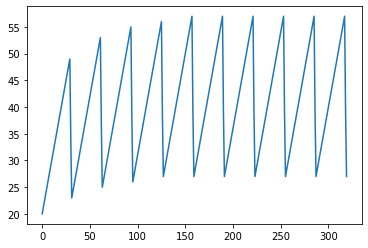

In [9]:
all_bs = []
curr_bs = 10
for _ in range(10):
    for _ in range(30):
        curr_bs = calculate_new_bs(curr_bs, True)
        all_bs.append(curr_bs)
    for _ in range(2):
        curr_bs = calculate_new_bs(curr_bs, False)
        all_bs.append(curr_bs)

plt.plot(all_bs)

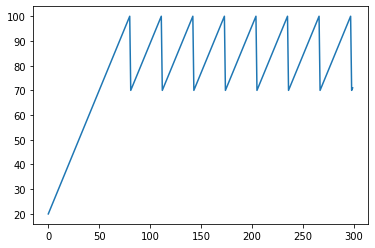

In [10]:
all_bs = []
curr_bs = 10
target = 90
for _ in range(300):
    if curr_bs > target * 1.1:
        curr_bs = calculate_new_bs(curr_bs, False)
    else:
        curr_bs = calculate_new_bs(curr_bs, True)

    all_bs.append(curr_bs)

plt.plot(all_bs)

# Test Changing The Configuration

In [11]:
# initialize
proxy_stats = get_proxy_stats()
curr_bs = proxy_stats['maxBufferSize']

In [12]:
acc_proxy_stats = []

for _ in tqdm(range(30*2)):
    proxy_stats = get_proxy_stats()
    acc_proxy_stats.append(proxy_stats)

    # the condition for increasing or decreasing batch size
    shouldIncrease = proxy_stats['reponseTimeP95'] < slo_target
    shouldIncrease = shouldIncrease and (proxy_stats['averageTimeoutRatio'] < average_timeout_ratio_threshold)

    new_bs = calculate_new_bs(curr_bs, shouldIncrease, bs_config)

    set_proxy_config({
        'maxBufferSize': new_bs,
        'maxBufferTimeoutMs': slo_target,
    })

    print(curr_bs, new_bs)
    print(proxy_stats['averageTimeoutRatio'])
    print('------')

    # update current batch size
    curr_bs = new_bs
    time.sleep(30)

  0%|          | 0/60 [00:00<?, ?it/s]

5 3
1
------
3 8
0.46808510638297873
------
8 5
1
------
5 3
0.9230769230769231
------
3 2
0.6097560975609756
------
2 7
0.2037037037037037
------
7 4
1
------
4 2
0.631578947368421
------
2 7
0.14583333333333334
------
7 4
1
------
4 2
0.5853658536585366
------
2 7
0.18032786885245902
------
7 4
1
------
4 2
0.6222222222222222
------
2 7
0.2692307692307692
------
7 4
1
------
4 2
0.96
------
2 7
0.23529411764705882
------
7 4
1
------
4 2
0.6923076923076923
------
2 7
0.20689655172413793
------
7 4
1
------
4 2
0.8571428571428571
------
2 7
0.14035087719298245
------
7 4
0.9487179487179487
------
4 2
0.6756756756756757
------
2 7
0.17307692307692307
------
7 4
1
------
4 9
0.48717948717948717
------
9 6
1
------
6 4
0.9166666666666666
------
4 2
0.75
------
2 7
0.1746031746031746
------
7 4
1
------
4 2
0.8235294117647058
------
2 7
0.3333333333333333
------
7 4
1
------
4 2
0.8055555555555556
------
2 7
0.19672131147540983
------
7 4
1
------
4 2
0.75
------
2 7
0.19230769230769232
-

In [13]:
df_proxy_stats = pd.DataFrame(data=acc_proxy_stats)
df_proxy_stats.head()

,maxBufferSize,averageMaxBufferSize,averageActualBatchSize,maxBufferTimeoutMs,currentReplicaCount,currentReadyReplicaCount,currentConcurrency,averageConcurrency,averageArrivalRate,averageDepartureRate,averageDispatchRate,averageErrorRate,averageTimeoutRatio,reponseTimeAverage,reponseTimeP50,reponseTimeP95,batchResponseTimeStats
0,5,5,2.441441,400,1,1,0,1.3,4.45,4.45,4.45,0,1.000000,259.653137,285.0,384.0,"{'1': {'values': [21, 23, 23, 23, 25, 26, 26, ..."
1,3,3,2.404959,400,1,1,1,0.8,5.65,5.60,5.60,0,0.468085,219.216495,228.0,384.5,"{'1': {'values': [20, 22, 22, 25, 25, 27, 28, ..."
2,8,8,2.508333,400,1,1,0,1.6,5.00,4.80,4.80,0,1.000000,223.946844,240.0,383.0,"{'1': {'values': [20, 22, 22, 23, 25, 27, 28, ..."
3,5,5,2.739130,400,1,1,0,1.1,5.15,5.25,5.25,0,0.923077,257.428571,290.0,383.0,"{'1': {'values': [21, 23, 23, 24, 25, 26, 27, ..."
4,3,3,2.508065,400,1,1,1,1.0,4.30,4.30,4.30,0,0.609756,230.877814,254.0,382.0,"{'1': {'values': [21, 21, 23, 23, 24, 24, 25, ..."


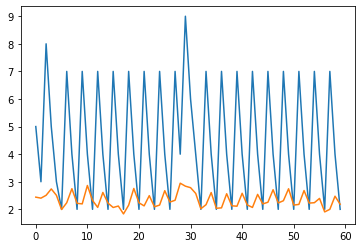

In [14]:
plt.plot(df_proxy_stats['averageMaxBufferSize'])
plt.plot(df_proxy_stats['averageActualBatchSize'])

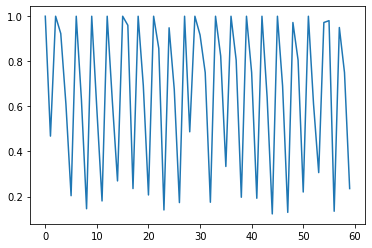

In [15]:
plt.plot(df_proxy_stats['averageTimeoutRatio'])

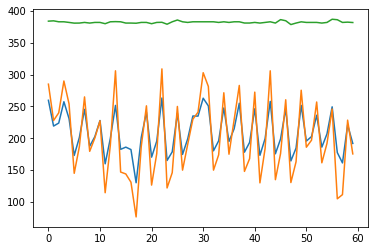

In [16]:
plt.plot(df_proxy_stats['reponseTimeAverage'])
plt.plot(df_proxy_stats['reponseTimeP50'])
plt.plot(df_proxy_stats['reponseTimeP95'])

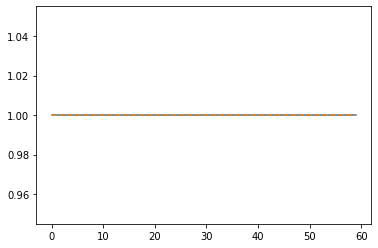

In [17]:
plt.plot(df_proxy_stats['currentReplicaCount'])
plt.plot(df_proxy_stats['currentReadyReplicaCount'], ls='--')